<a href="https://colab.research.google.com/github/OscarSaxonBuisness/PortfolioProjects/blob/main/PneumoniaImageDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oscarsaxon","key":"aa527a4c7308f3e120b65780d4e837c0"}'}

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip
!ls chest_xray


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:17<00:00, 73.5MB/s]
100% 2.29G/2.29G [00:17<00:00, 138MB/s] 
chest_xray  __MACOSX  test  train  val


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/content/chest_xray/train"
val_dir   = "/content/chest_xray/val"
test_dir  = "/content/chest_xray/test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # important for metrics
)

print("Classes:", train_generator.class_indices)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # 0 = NORMAL, 1 = PNEUMONIA
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,563,713 (36.48 MB)

 Trainable params: 9,563,713 (36.48 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    train_generator,
    epochs=10,                 # you can change this to 5, 15, etc
    validation_data=val_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 464ms/step - accuracy: 0.7070 - loss: 0.6482 - val_accuracy: 0.6875 - val_loss: 0.7254
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 413ms/step - accuracy: 0.8636 - loss: 0.3341 - val_accuracy: 0.8750 - val_loss: 0.4843
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 399ms/step - accuracy: 0.9032 - loss: 0.2390 - val_accuracy: 0.7500 - val_loss: 0.5116
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 405ms/step - accuracy: 0.9248 - loss: 0.1914 - val_accuracy: 0.7500 - val_loss: 0.4956
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.9253 - loss: 0.1814 - val_accuracy: 0.7500 - val_loss: 0.7336
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - accuracy: 0.9230 - loss: 0.1983 - val_accuracy: 0.8125 - val_loss: 0.3599
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.9362 - loss: 0.1673 - val_accuracy: 0.7500 - val_loss: 0.6511
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - accuracy: 0.9426 - loss: 0

In [10]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)

# Predictions
y_prob = model.predict(test_generator)
y_pred = (y_prob > 0.5).astype("int32").reshape(-1)
y_true = test_generator.classes

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification report:")
print(classification_report(
    y_true, y_pred,
    target_names=["NORMAL", "PNEUMONIA"]
))


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.7666 - loss: 0.6662
Test accuracy: 0.8525640964508057
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step
Confusion matrix:
[[152  82]
 [ 10 380]]

Classification report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.65      0.77       234
   PNEUMONIA       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



Saving pNEUMONIA 3.jpeg to pNEUMONIA 3.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: PNEUMONIA


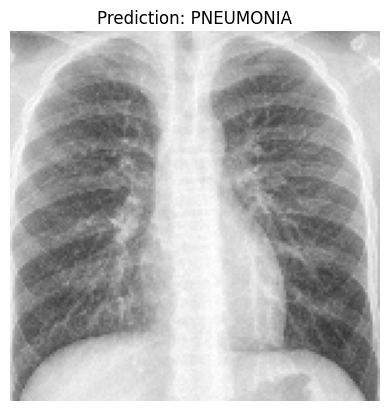

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()   # Upload ONE chest x-ray image (jpg/png)

img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

prediction = model.predict(img_array)[0][0]

if prediction > 0.5:
    result = "PNEUMONIA"
else:
    result = "NORMAL"

print("Prediction:", result)

plt.imshow(img)
plt.title("Prediction: " + result)
plt.axis("off")
plt.show()
